In [1]:
'''
Program to perform 3D element analysis
Unit: mm
Author: Yitian Shao
Created on 2021.06.02
'''
%matplotlib notebook 

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

meshDensity = 100 # density of vertices of the mesh, large value results in finer grid but larger memory demand
adPlotDensity = 100 # density of additive plot of curves and circles

In [2]:
'''
Simulation parameters 
'''
R = 50 # (mm) Radius of the sphere
f = 20 # (mm) Offset distance of the front cut from the center of the sphere
#m = 34.641 # (mm) half-length of the open area of the pouch, m < r
m = 20

# r = np.sqrt(R**2 - f**2) # Radius of the front cutting circle, r < R
# h = np.sqrt(r**2 - m**2) # (mm) Cutting height of the sphere, Pouch height will be 2(r-h)
# alpha = np.arccos(h/r) # Angle viewing from the front
# s = np.sqrt(m**2 + f**2) # Radius of the top cutting circle
# beta = np.arctan(m/(f + s)) # Angle viewing from the top
# n = s * np.cos(beta)
# rSide = np.sqrt(n**2 + h**2)

#print("r = %.2f mm, h = %.2f mm, s = %.2f mm, n = %.2f mm, rSide = %.2f mm" % (r, h, s, n, rSide))
# print("Angle: Alpha = %.1f degree, Beta = %.1f degree" % (180*alpha/np.pi, 180*beta/np.pi))

# # Side circle coordinates
# triangleTopX = R - s
# cCenterX = n * np.cos(beta) + triangleTopX
# cCenterY = -n * np.sin(beta)
# triangleBottomX = 2 * n * np.cos(beta) + triangleTopX
#print("triangle with top at (%.2f, %.2f, %.2f) and left bottom at (%.2f, %.2f, %.2f)" % (triangleTopX, 0, h,
                                                                                         #triangleBottomX, -m, h))

In [3]:
'''
General Functions
'''
def data_cut(x, y, z, ind):
    return x[ind], y[ind], z[ind]

def coordTrans2D(a, b, theta, a_translate, b_translate):
    # 2D coordinate transformation, rotate counter-clockwise by angle theta and then translate
    rotMat = np.array([[np.cos(theta), -np.sin(theta)],
                  [np.sin(theta), np.cos(theta)]])
    ab = np.matmul(rotMat, np.stack((a, b)))
    ab[0,:] += a_translate
    ab[1,:] += b_translate
    return ab

def fitPlane2Points(p1, p2, p3):
    # Fit a plane to three nonalighed points
    return np.cross(p1 - p2, p3 - p2)

In [4]:
'''
Class
'''
class TrianglePouch:
    def __init__(self, R = 50, f = 20, m = 34.641, meshDensity = 100):
        self.R = R
        self.f = f
        self.m = m
        self.meshDensity = meshDensity
        self.triangle = []
        self.frontCircle = []
        self.frontLine = []
        self.leftCircle = []
        self.rightCircle = []
        self.adPlotDensity = []
        
        self.r = np.sqrt(self.R**2 - self.f**2) # Radius of the front cutting circle, r < R
        self.h = np.sqrt(self.r**2 - self.m**2) # (mm) Cutting height of the sphere, Pouch height will be 2(r-h)
        self.alpha = np.arccos(self.h/self.r) # Angle viewing from the front
        self.s = np.sqrt(self.m**2 + self.f**2) # Radius of the top cutting circle
        self.beta = np.arctan(self.m/(self.f + self.s)) # Angle viewing from the top
        self.n = self.s * np.cos(self.beta)
        self.rSide = np.sqrt(self.n**2 + self.h**2)
        
        # Side circle coordinates
        self.triangleTopX = self.R - self.s
        self.cCenterX = self.n * np.cos(self.beta) + self.triangleTopX
        self.cCenterY = -self.n * np.sin(self.beta)
        self.triangleBottomX = 2 * self.n * np.cos(self.beta) + self.triangleTopX
        
        # Generate the mesh of the triangle pouch
        x = np.outer(np.linspace(0, 2*R, self.meshDensity), np.ones(self.meshDensity))
        y = np.outer(np.linspace(-R, R, self.meshDensity), np.ones(self.meshDensity)).T
        z = R**2 - (x-R)**2 - (y**2)

        # Keep sphere surface
        keepInd = (z >= 0)
        x, y, z = data_cut(x, y, z, keepInd)
        z = np.sqrt(z)

        # Cut the sphere
        keepInd = (z >= self.h)
        x, y, z = data_cut(x, y, z, keepInd)

        # Cut the Front Face (surface crossing the pouch)
        keepInd = (x <= self.f + self.R)
        x, y, z = data_cut(x, y, z, keepInd)

        # Cut the left-side face
        pNormVector = fitPlane2Points(np.array([self.triangleTopX, 0, self.h]), np.array([self.cCenterX, self.cCenterY, 0]), 
                                      np.array([self.triangleBottomX, -self.m, self.h]))
        keepInd = (np.matmul(pNormVector, np.stack((x - self.cCenterX, y - self.cCenterY, z))) >= 0)
        x, y, z = data_cut(x, y, z, keepInd)

        # Cut the right-side face
        pNormVector2 = fitPlane2Points(np.array([self.triangleTopX, 0, self.h]), np.array([self.cCenterX, -self.cCenterY, 0]), 
                                      np.array([self.triangleBottomX, self.m, self.h]))
        keepInd = (np.matmul(pNormVector2, np.stack((x - self.cCenterX, y + self.cCenterY, z))) <= 0)
        x, y, z = data_cut(x, y, z, keepInd)
        
        self.triangle = np.stack((x, y, z)) # Vertex coordinate of the triangle pouch
        
    def printInfo(self):
        print("r = %.2f mm, h = %.2f mm, s = %.2f mm, n = %.2f mm, rSide = %.2f mm" % (self.r, self.h, self.s, self.n,
                                                                                       self.rSide))
        print("Angle: Alpha = %.1f degree, Beta = %.1f degree" % (180*self.alpha/np.pi, 180*self.beta/np.pi))
        print("triangle with top at (%.2f, %.2f, %.2f) and left bottom at (%.2f, %.2f, %.2f)" % 
              (self.triangleTopX, 0, self.h, self.triangleBottomX, -self.m, self.h))

    def additiveLine(self, adPlotDensity, dispCurve = True):
        self.adPlotDensity = adPlotDensity
        
        # Front circle and line
        fAngle = np.linspace(0, 2*np.pi, self.adPlotDensity)
        x = (self.R + self.f) * np.ones(self.adPlotDensity)
        y = self.r * np.cos(fAngle)
        z = self.r * np.sin(fAngle)
        self.frontCircle = np.stack((x, y, z)) # Vertex coordinate of the front circle
        if(dispCurve):
            keepInd = (z >= self.h)
            self.frontCircle = self.frontCircle[:, keepInd]
        
        self.frontLine = np.array([[self.R + self.f, self.R + self.f], [-self.m, self.m],
                                   [self.h, self.h]]) # Coordinate of the front line
        
        # Side circle and line
        x, y = coordTrans2D(self.rSide * np.cos(fAngle), np.zeros(self.adPlotDensity), -self.beta, 
                            self.cCenterX, self.cCenterY)
        z = self.rSide * np.sin(fAngle)
        self.leftCircle = np.stack((x, y, z)) # Vertex coordinate of the left side circle
        if(dispCurve):
            keepInd = (z >= self.h)
            self.leftCircle = self.leftCircle[:, keepInd]
            
        self.leftLine = np.array([[self.triangleTopX, self.triangleBottomX], [0, -self.m], [self.h, self.h]])
        ###leftRadiusLine = np.array([[triangleTopX, cCenterX], [0, cCenterY], [h, 0]])# For reference only

        x, y = coordTrans2D(self.rSide * np.cos(fAngle), np.zeros(self.adPlotDensity), self.beta, 
                            self.cCenterX, -self.cCenterY)
        self.rightCircle = np.stack((x, y, z)) # Vertex coordinate of the left side circle
        if(dispCurve):
            keepInd = (z >= self.h)
            self.rightCircle = self.rightCircle[:, keepInd]
            
        self.rightLine = np.array([[self.triangleTopX, self.triangleBottomX], [0, self.m], [self.h, self.h]])
        

r = 45.83 mm, h = 41.23 mm, s = 28.28 mm, n = 26.13 mm, rSide = 48.81 mm
Angle: Alpha = 25.9 degree, Beta = 22.5 degree
triangle with top at (21.72, 0.00, 41.23) and left bottom at (70.00, -20.00, 41.23)


<IPython.core.display.Javascript object>


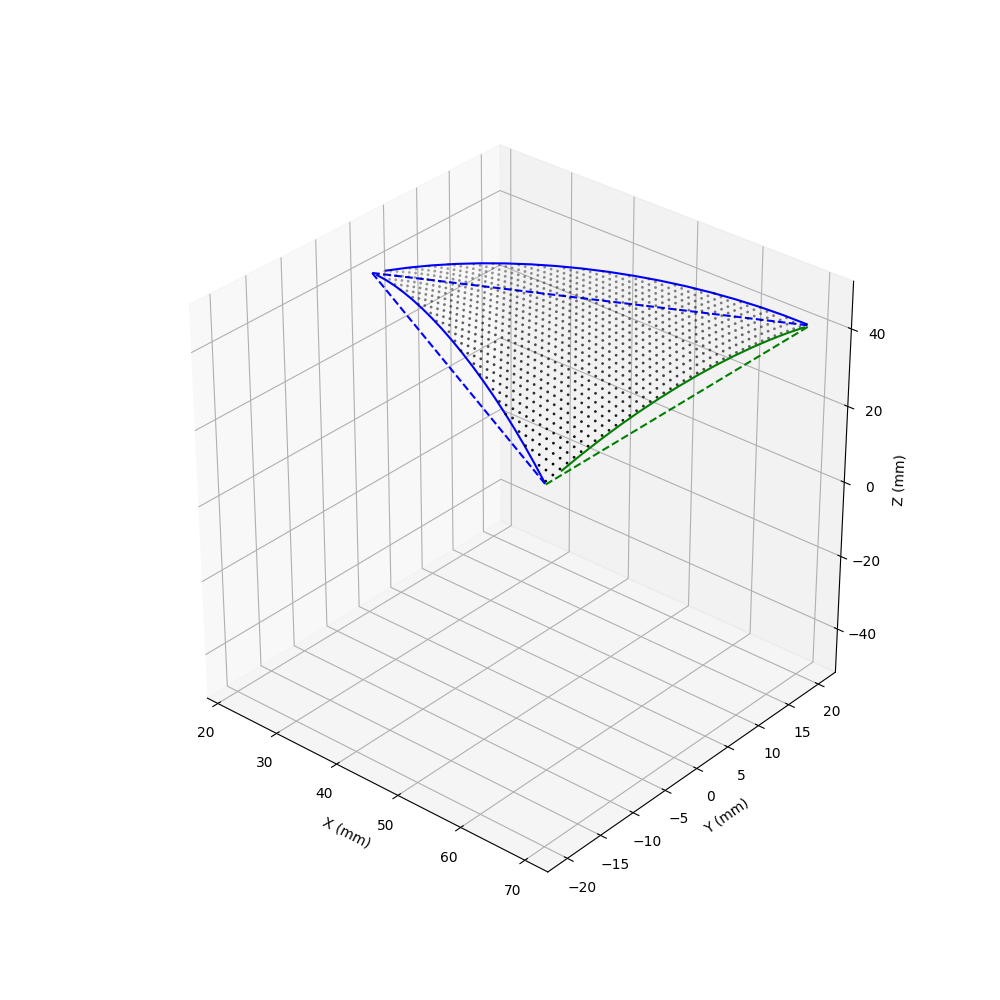

In [5]:
triPouch0 = TrianglePouch(R, f, m, meshDensity)
triPouch0.printInfo()

fig1 = plt.figure(figsize = (10,10))
ax = fig1.add_subplot(111, projection='3d')
# Plot the triangle pouch
ax.scatter3D(triPouch0.triangle[0,:], triPouch0.triangle[1,:], triPouch0.triangle[2,:], 
             s = 1, edgecolor="k", facecolor="none")
ax.set_xlabel('X (mm)')
ax.set_ylabel('Y (mm)')
ax.set_zlabel('Z (mm)')
ax.set_zlim3d([-R, R])
ax.set_box_aspect([1.0, 1.0, 1.0])
plt.show()

# Additive plot
triPouch0.additiveLine(adPlotDensity)
# Plot front circle
ax.plot(triPouch0.frontCircle[0,:], triPouch0.frontCircle[1,:], triPouch0.frontCircle[2,:], c = 'g')
# Plot front line
ax.plot(triPouch0.frontLine[0,:], triPouch0.frontLine[1,:], triPouch0.frontLine[2,:], '--', c = 'g')
# Plot left circle
ax.plot(triPouch0.leftCircle[0,:], triPouch0.leftCircle[1,:], triPouch0.leftCircle[2,:], c = 'b')
# Plot left line
ax.plot(triPouch0.leftLine[0,:], triPouch0.leftLine[1,:], triPouch0.leftLine[2,:], '--', c = 'b')
# Plot right circle
ax.plot(triPouch0.rightCircle[0,:], triPouch0.rightCircle[1,:], triPouch0.rightCircle[2,:], c = 'b')
# Plot right line
ax.plot(triPouch0.rightLine[0,:], triPouch0.rightLine[1,:], triPouch0.rightLine[2,:], '--', c = 'b')


In [6]:
# Plot entire pouch
